In [32]:
import matplotlib.pyplot as plt
import torch
from typing import List

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
df_orig, metadata = nnts.data.load("electricity")
params = nnts.models.Hyperparams()
splitter = nnts.data.PandasSplitter()
model_name = "seg-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [35]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )

# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

# Models with short forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario = nnts.experiments.CovariateScenario(
            covariates, error, covariates=covariates
        )
        scenario_list.append(scenario)

In [26]:
for scenario in scenario_list:
    metadata.context_length = metadata.prediction_length * 3 + 1
    params.batches_per_epoch = 500
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.SegLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
        metadata.seasonality
        
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(8, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=8, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-42.pt
{'train_loss': 8.7784423828125, 'valid_loss': 7.7752604484558105, 'elapsed_time': 1.127450249856338}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-42.pt
{'train_loss': 4.297869682312012, 'valid_loss': 0.7463834881782532, 'elapsed_time': 1.3045425419695675}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-42.pt
{'train_loss': 1.8862789869308472, 'valid_loss': 0.6951506733894348, 'elapsed_time': 1.2291690411511809}
{'train_loss': 1.3014429807662964, 'valid_loss': 0.7151018381118774, 'elapsed_time': 1.176481458125636}
{'train_loss': 0.902869701385498, 'valid_loss'

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(8, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=8, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-43.pt
{'train_loss': 7.693552017211914, 'valid_loss': 5.110839366912842, 'elapsed_time': 1.0672581249382347}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-43.pt
{'train_loss': 2.8393375873565674, 'valid_loss': 0.8548830151557922, 'elapsed_time': 1.0813228748738766}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-43.pt
{'train_loss': 1.616156816482544, 'valid_loss': 0.6764129996299744, 'elapsed_time': 1.1075176671147346}
{'train_loss': 0.9984332919120789, 'valid_loss': 0.7066506147384644, 'elapsed_time': 1.0235164579935372}
{'train_loss': 0.6926731467247009, 'valid_l

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(8, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=8, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-44.pt
{'train_loss': 6.736227512359619, 'valid_loss': 4.980723857879639, 'elapsed_time': 1.057396334130317}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-44.pt
{'train_loss': 2.6375651359558105, 'valid_loss': 0.7089256644248962, 'elapsed_time': 1.0633910838514566}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-44.pt
{'train_loss': 1.504396915435791, 'valid_loss': 0.685009777545929, 'elapsed_time': 1.0552017919253558}
{'train_loss': 0.9828572869300842, 'valid_loss': 0.7101113200187683, 'elapsed_time': 1.0582989579997957}
{'train_loss': 0.7008960843086243, 'valid_los

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(8, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=8, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-45.pt
{'train_loss': 9.527629852294922, 'valid_loss': 7.659564971923828, 'elapsed_time': 1.0180717918556184}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-45.pt
{'train_loss': 4.154117107391357, 'valid_loss': 0.7027074098587036, 'elapsed_time': 0.9964301250874996}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-45.pt
{'train_loss': 1.9792603254318237, 'valid_loss': 0.6901450753211975, 'elapsed_time': 1.0264500409830362}
{'train_loss': 1.1701679229736328, 'valid_loss': 0.7246658205986023, 'elapsed_time': 1.0491354579571635}
Artifact saved to results/seg-lstm/traffic/

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 4.0974607, 'mae': 1.1672857999801636, 'mape': inf, 'smape': 0.12971433997154236, 'abs_error': 8049.603, 'mase': 0.28285217, 'rmse': 1.5866965055465698}
Run cov-0-pearsn-0-pl-8-seed-45 finished
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(8, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=8, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-46.pt
{'train_loss': 8.29246997833252, 'valid_loss': 6.268214702606201, 'elapsed_time': 1.120647249976173}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-46.pt
{'train_loss': 3.4068233966827393, 'valid_loss': 0.7072558403015137, 'elapsed_time': 1.0872315000742674}
Artifact saved to results/seg-lstm/traffic/cov-0-pearsn-0-pl-8-seed-46.pt
{'train_loss': 1.8198336362838745, 'valid_loss': 0.67

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=1.0, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 9.010333061218262, 'valid_loss': 8.090210914611816, 'elapsed_time': 1.0983646668028086}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 4.757814884185791, 'valid_loss': 1.1444100141525269, 'elapsed_time': 1.12129499996081}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 1.6851847171783447, 'valid_loss': 0.6998293995857239, 'elapsed_time': 1.066423290874809}
{'train_loss': 1.1018989086151123, 'valid_loss': 0.7176682353019714, 'elapsed_time': 1.09439825010485

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9734762891368408, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 9.012120246887207, 'valid_loss': 8.084327697753906, 'elapsed_time': 0.9864350419957191}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 4.77195930480957, 'valid_loss': 1.1921160221099854, 'elapsed_time': 0.9456180420238525}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 1.7574936151504517, 'valid_loss': 0.7989621758460999, 'elapsed_time': 0.9396334160119295}
{'train_loss': 1.1922979354858398, 'valid_loss': 0.8116742372512817, 'elapsed_tim

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9050352330593034, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 9.015610694885254, 'valid_loss': 8.087968826293945, 'elapsed_time': 0.9850617500487715}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 4.821749210357666, 'valid_loss': 1.3223304748535156, 'elapsed_time': 0.9581667920574546}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 1.9268566370010376, 'valid_loss': 1.0206936597824097, 'elapsed_time': 0.9437366670463234}
{'train_loss': 1.3919426202774048, 'valid_loss': 1.0265097618103027, 'elapsed_ti

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.8173705894712557, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 9.020852088928223, 'valid_loss': 8.097630500793457, 'elapsed_time': 0.9799867500551045}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 4.906745433807373, 'valid_loss': 1.4939814805984497, 'elapsed_time': 1.0259381248615682}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 2.1629626750946045, 'valid_loss': 1.2936208248138428, 'elapsed_time': 1.0305327910464257}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.82-pl-8-seed-42.pt
{'t

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.7287625793743431, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 9.030282020568848, 'valid_loss': 8.095170974731445, 'elapsed_time': 1.0126878330484033}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 4.987753391265869, 'valid_loss': 1.7262147665023804, 'elapsed_time': 1.0824322500266135}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 2.4080193042755127, 'valid_loss': 1.5810394287109375, 'elapsed_time': 1.2002174581866711}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.73-pl-8-seed-42.pt
{'t

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.6483279278893316, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 9.057890892028809, 'valid_loss': 8.11666202545166, 'elapsed_time': 0.9547850419767201}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 5.11659049987793, 'valid_loss': 1.9754117727279663, 'elapsed_time': 0.9550576668698341}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 2.675506830215454, 'valid_loss': 1.8787661790847778, 'elapsed_time': 0.9397548330016434}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.65-pl-8-seed-42.pt
{'trai

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.5787754959386153, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 9.114659309387207, 'valid_loss': 8.172516822814941, 'elapsed_time': 0.984437334118411}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 5.28989839553833, 'valid_loss': 2.251417398452759, 'elapsed_time': 1.0082139999140054}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 2.9654879570007324, 'valid_loss': 2.185554027557373, 'elapsed_time': 0.9400187500286847}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.58-pl-8-seed-42.pt
{'train

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.519786682090601, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 9.205102920532227, 'valid_loss': 8.267105102539062, 'elapsed_time': 0.9531231671571732}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 5.491405010223389, 'valid_loss': 2.518502712249756, 'elapsed_time': 1.0023872088640928}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 3.255826473236084, 'valid_loss': 2.4979248046875, 'elapsed_time': 0.9783421251922846}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-0.52-pl-8-seed-42.pt
{'train_l

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=1.0, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 8.450430870056152, 'valid_loss': 7.689424991607666, 'elapsed_time': 0.9577026672195643}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 4.672644138336182, 'valid_loss': 1.0979827642440796, 'elapsed_time': 0.9684499159920961}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 1.5477771759033203, 'valid_loss': 0.7229405641555786, 'elapsed_time': 0.9642246251460165}
{'train_loss': 1.0571479797363281, 'valid_loss': 0.7315232157707214, 'elapsed_time': 0.92740141600

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9734762891368408, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 8.450579643249512, 'valid_loss': 7.691417694091797, 'elapsed_time': 0.8761507498566061}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 4.693641662597656, 'valid_loss': 1.1863535642623901, 'elapsed_time': 0.8974579591304064}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 1.6458560228347778, 'valid_loss': 0.8490892052650452, 'elapsed_time': 0.9315560418181121}
{'train_loss': 1.1712315082550049, 'valid_loss': 0.8551990389823914, 'elapsed_ti

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9050352330593034, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 8.452310562133789, 'valid_loss': 7.701619625091553, 'elapsed_time': 0.9497741251252592}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 4.768002510070801, 'valid_loss': 1.4541947841644287, 'elapsed_time': 0.9400642500258982}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 1.884103536605835, 'valid_loss': 1.1355857849121094, 'elapsed_time': 0.9056663748342544}
{'train_loss': 1.4517654180526733, 'valid_loss': 1.1359442472457886, 'elapsed_tim

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.8173705894712557, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 8.457398414611816, 'valid_loss': 7.717092990875244, 'elapsed_time': 0.9234995001461357}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 4.885962009429932, 'valid_loss': 1.8178470134735107, 'elapsed_time': 0.9726498750969768}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 2.1929080486297607, 'valid_loss': 1.490168809890747, 'elapsed_time': 0.9364940419327468}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.82-pl-8-seed-42.pt
{'tr

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.7287625793743431, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 8.477493286132812, 'valid_loss': 7.743694305419922, 'elapsed_time': 0.9597774168942124}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 5.099635601043701, 'valid_loss': 2.114619493484497, 'elapsed_time': 0.9479085421189666}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 2.5235488414764404, 'valid_loss': 1.875154733657837, 'elapsed_time': 1.0953890408854932}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.73-pl-8-seed-42.pt
{'tra

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 2.0049834, 'mae': 0.8758018612861633, 'mape': inf, 'smape': 0.09155084192752838, 'abs_error': 6039.53, 'mase': 0.21387751, 'rmse': 1.0945014953613281}
Run cov-2-pearsn-0.73-pl-8-seed-42 finished
PearsonRResult(statistic=0.6483279278893316, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 8.529294967651367, 'valid_loss': 7.810251712799072, 'elapsed_time': 1.006711999885738}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 5.289008140563965, 'valid_loss': 2.4042856693267822, 'elapsed_time': 1.1422439168673009}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.65

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.5787754959386153, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 8.623571395874023, 'valid_loss': 7.919773578643799, 'elapsed_time': 0.9924615409690887}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 5.539421558380127, 'valid_loss': 2.831019163131714, 'elapsed_time': 1.057066917186603}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 3.2758429050445557, 'valid_loss': 2.6874966621398926, 'elapsed_time': 0.954264875035733}
{'train_loss': 2.948556423187256, 'valid_loss': 2.6895861625671387, 'elapsed_time':

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.519786682090601, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 8.762392044067383, 'valid_loss': 8.068788528442383, 'elapsed_time': 0.9039713749662042}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 5.8228373527526855, 'valid_loss': 3.3145320415496826, 'elapsed_time': 0.892955708084628}
Artifact saved to results/seg-lstm/traffic/cov-2-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 3.6797285079956055, 'valid_loss': 3.102144241333008, 'elapsed_time': 0.9486978338100016}
{'train_loss': 3.340930700302124, 'valid_loss': 3.1089653968811035, 'elapsed_time'

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=1.0, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 8.519306182861328, 'valid_loss': 7.373374938964844, 'elapsed_time': 0.9120802499819547}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 5.212088584899902, 'valid_loss': 2.5908892154693604, 'elapsed_time': 0.9606428749393672}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 1.9583954811096191, 'valid_loss': 0.7659164667129517, 'elapsed_time': 0.8966594999656081}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-1.0-pl-8-seed-42.pt
{'train_loss': 1.10014

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9734762891368408, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 8.518781661987305, 'valid_loss': 7.371602535247803, 'elapsed_time': 0.8698171251453459}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 5.239492416381836, 'valid_loss': 2.6448097229003906, 'elapsed_time': 0.8565570830833167}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.97-pl-8-seed-42.pt
{'train_loss': 2.043159246444702, 'valid_loss': 0.9038519263267517, 'elapsed_time': 0.8840426669921726}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.97-pl-8-seed-42.pt
{'tr

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9050352330593034, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 8.520342826843262, 'valid_loss': 7.378424644470215, 'elapsed_time': 0.8768869170453399}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 5.315993785858154, 'valid_loss': 2.7704598903656006, 'elapsed_time': 0.9313519580755383}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.91-pl-8-seed-42.pt
{'train_loss': 2.2525196075439453, 'valid_loss': 1.2165685892105103, 'elapsed_time': 0.8693390840198845}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.91-pl-8-seed-42.pt
{'t

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.8173705894712557, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 8.528470039367676, 'valid_loss': 7.409226894378662, 'elapsed_time': 0.8785842081997544}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 5.439413547515869, 'valid_loss': 2.9657301902770996, 'elapsed_time': 0.9151026250328869}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.82-pl-8-seed-42.pt
{'train_loss': 2.5420074462890625, 'valid_loss': 1.6046720743179321, 'elapsed_time': 0.9025711670983583}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.82-pl-8-seed-42.pt
{'t

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.7287625793743431, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 8.554116249084473, 'valid_loss': 7.484012126922607, 'elapsed_time': 0.856050583999604}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 5.606320858001709, 'valid_loss': 3.213005542755127, 'elapsed_time': 0.873351541813463}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.73-pl-8-seed-42.pt
{'train_loss': 2.888214349746704, 'valid_loss': 2.030773639678955, 'elapsed_time': 0.9337061669211835}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.73-pl-8-seed-42.pt
{'train_

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.6483279278893316, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 8.610663414001465, 'valid_loss': 7.608729362487793, 'elapsed_time': 0.9411820829845965}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 5.818469524383545, 'valid_loss': 3.526893138885498, 'elapsed_time': 0.8981296659912914}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.65-pl-8-seed-42.pt
{'train_loss': 3.2762932777404785, 'valid_loss': 2.4777467250823975, 'elapsed_time': 0.9220147500745952}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.65-pl-8-seed-42.pt
{'tr

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.5787754959386153, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 8.708968162536621, 'valid_loss': 7.778562068939209, 'elapsed_time': 0.939998917048797}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 6.068037033081055, 'valid_loss': 3.804464101791382, 'elapsed_time': 1.0428805421106517}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.58-pl-8-seed-42.pt
{'train_loss': 3.6523895263671875, 'valid_loss': 2.9411721229553223, 'elapsed_time': 0.9521807499695569}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.58-pl-8-seed-42.pt
{'tra

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.519786682090601, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(32, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=32, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 8.852429389953613, 'valid_loss': 7.986571788787842, 'elapsed_time': 1.06416454189457}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 6.33558464050293, 'valid_loss': 4.113363742828369, 'elapsed_time': 1.0677425838075578}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.52-pl-8-seed-42.pt
{'train_loss': 4.064123153686523, 'valid_loss': 3.410865068435669, 'elapsed_time': 0.9337824590038508}
Artifact saved to results/seg-lstm/traffic/cov-3-pearsn-0.52-pl-8-seed-42.pt
{'train_lo

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=1.0, pvalue=0.0)
SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=16, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-1.0-pl-1-seed-42.pt
{'train_loss': 9.010333061218262, 'valid_loss': 8.090210914611816, 'elapsed_time': 0.9868122909683734}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-1.0-pl-1-seed-42.pt
{'train_loss': 4.757814884185791, 'valid_loss': 1.1444100141525269, 'elapsed_time': 0.9916763328947127}
Artifact saved to results/seg-lstm/traffic/cov-1-pearsn-1.0-pl-1-seed-42.pt
{'train_loss': 1.6851847171783447, 'valid_loss': 0.6998293995857239, 'elapsed_time': 0.9839778749737889}
{'train_loss': 1.1018989086151123, 'valid_loss': 0.7176682353019714, 'elapsed_time': 0.97258891607

In [27]:
scenario_list = [
    nnts.experiments.CovariateScenario(
        1, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        2, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        3, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
]

In [28]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    _, _, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.SegLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        1,
        metadata.seasonality,
    )
    best_state_dict = torch.load(
        f"{PATH}/cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{metadata.prediction_length}-seed-{scenario.seed}.pt"
    )
    net.load_state_dict(best_state_dict)
    evaluator = nnts.torch.models.trainers.TorchEvaluator(net)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

{'mse': 0.92987895, 'mae': 0.6114678382873535, 'mape': 0.06296285, 'smape': 0.06266171485185623, 'abs_error': 527.0853, 'mase': 0.1457026, 'rmse': 0.6114678382873535}
Run cov-0-pearsn-0-pl-1-seed-42 finished


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 1.1174918, 'mae': 0.6373687386512756, 'mape': inf, 'smape': 0.06538785248994827, 'abs_error': 1098.8237, 'mase': 0.15189835, 'rmse': 0.6835861206054688}
Run cov-0-pearsn-0-pl-2-seed-42 finished
{'mse': 1.5076189, 'mae': 0.691177487373352, 'mape': inf, 'smape': 0.07040151208639145, 'abs_error': 1787.385, 'mase': 0.16277668, 'rmse': 0.7818706035614014}
Run cov-0-pearsn-0-pl-3-seed-42 finished


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


In [29]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

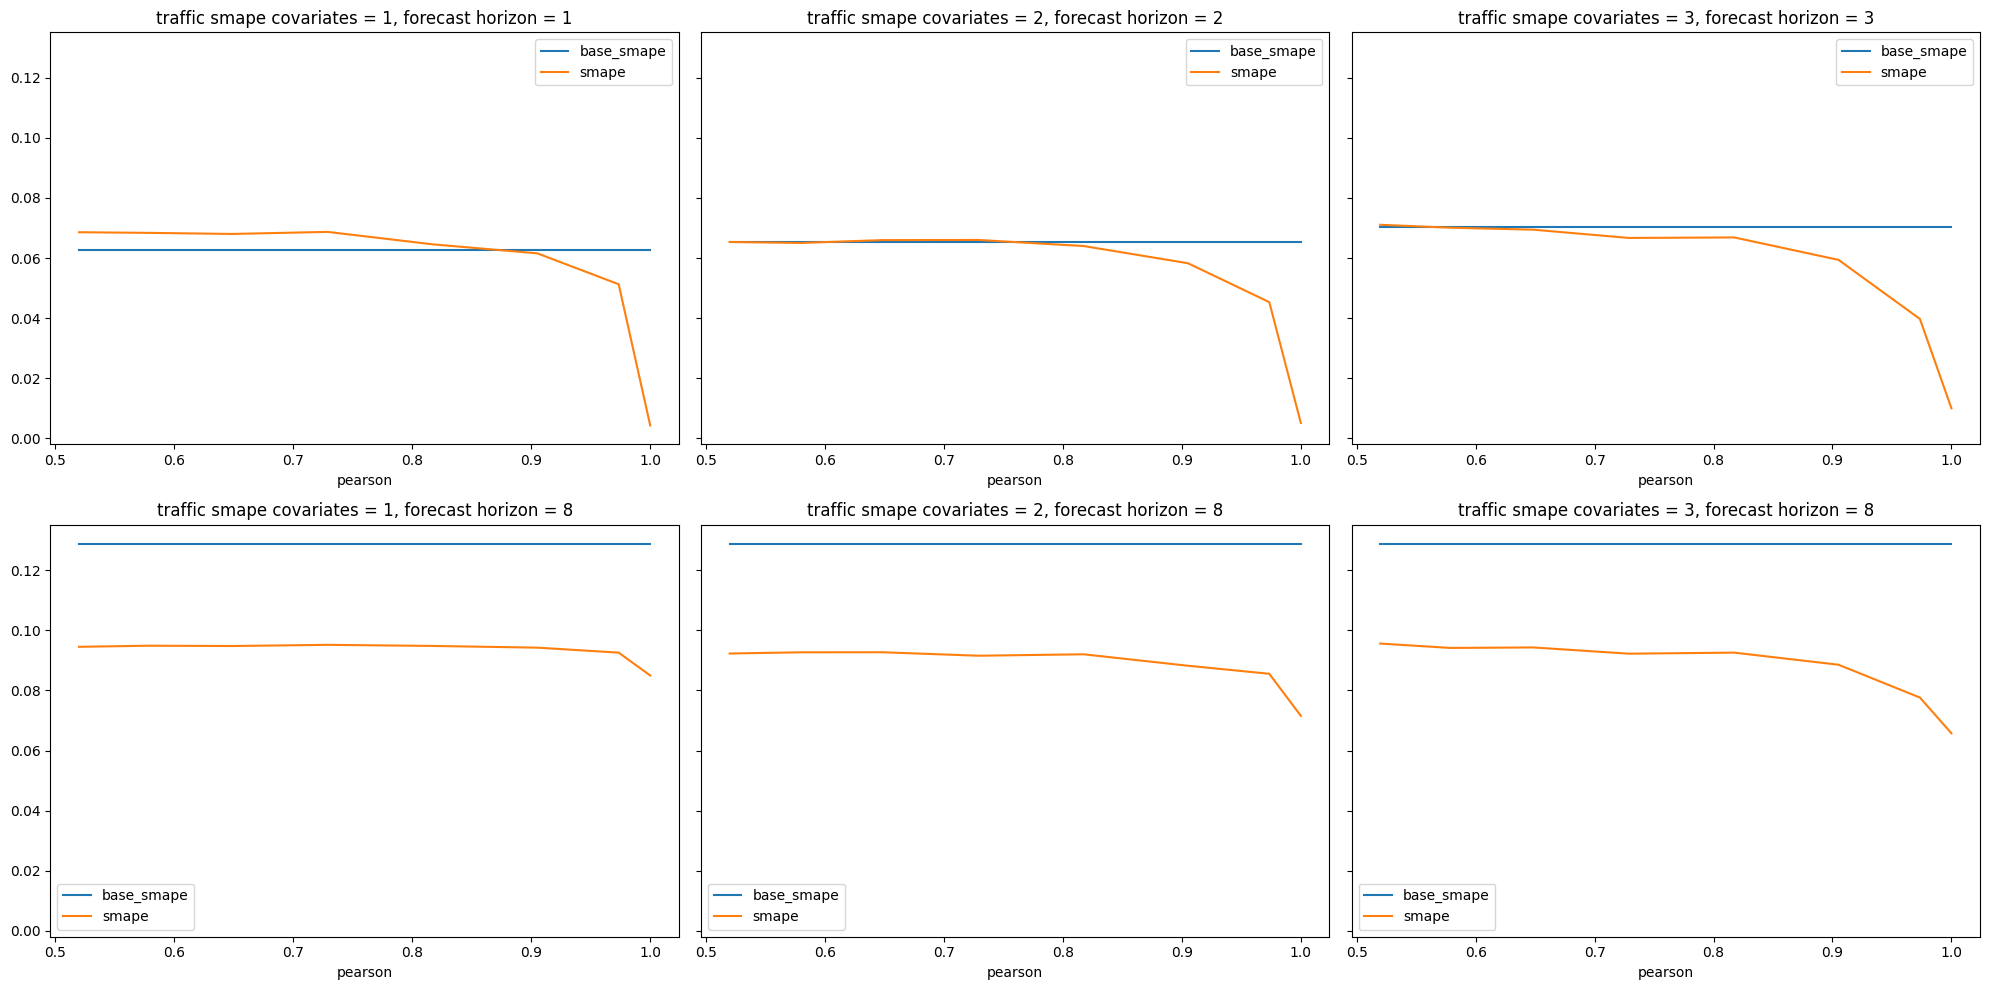

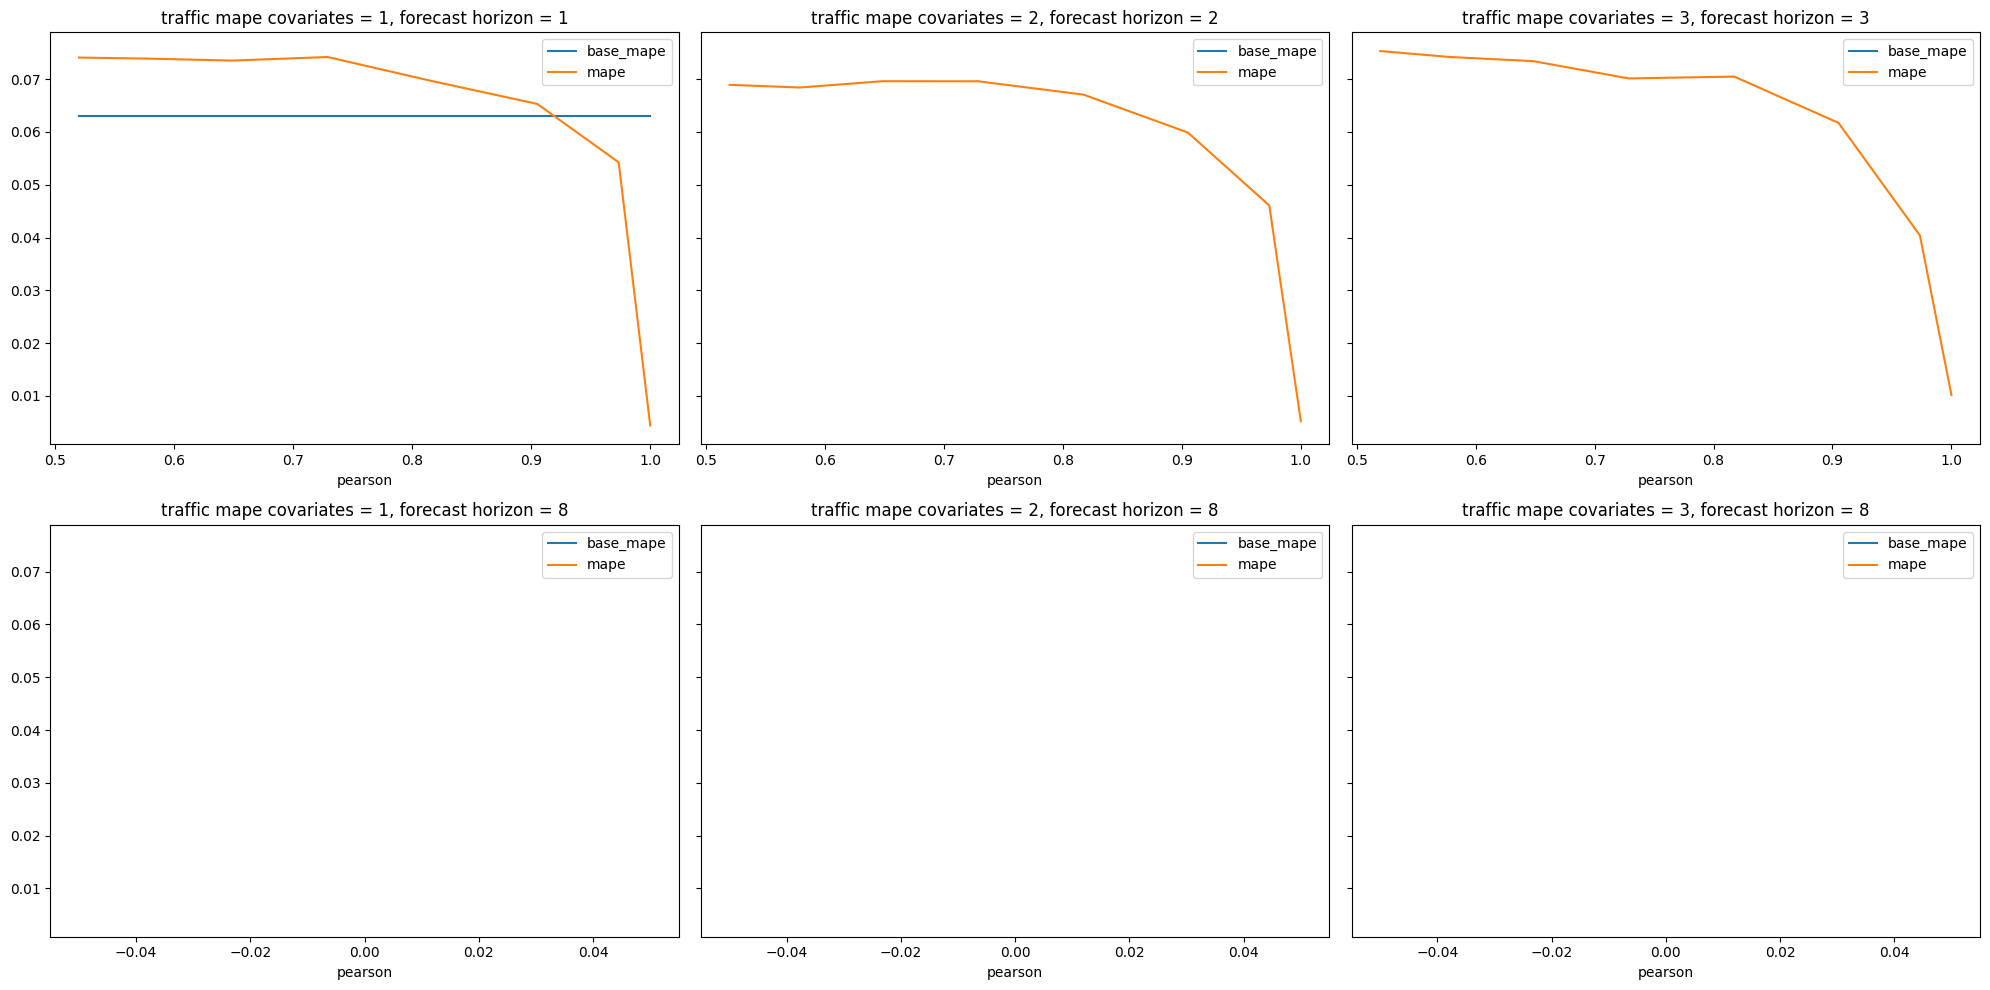

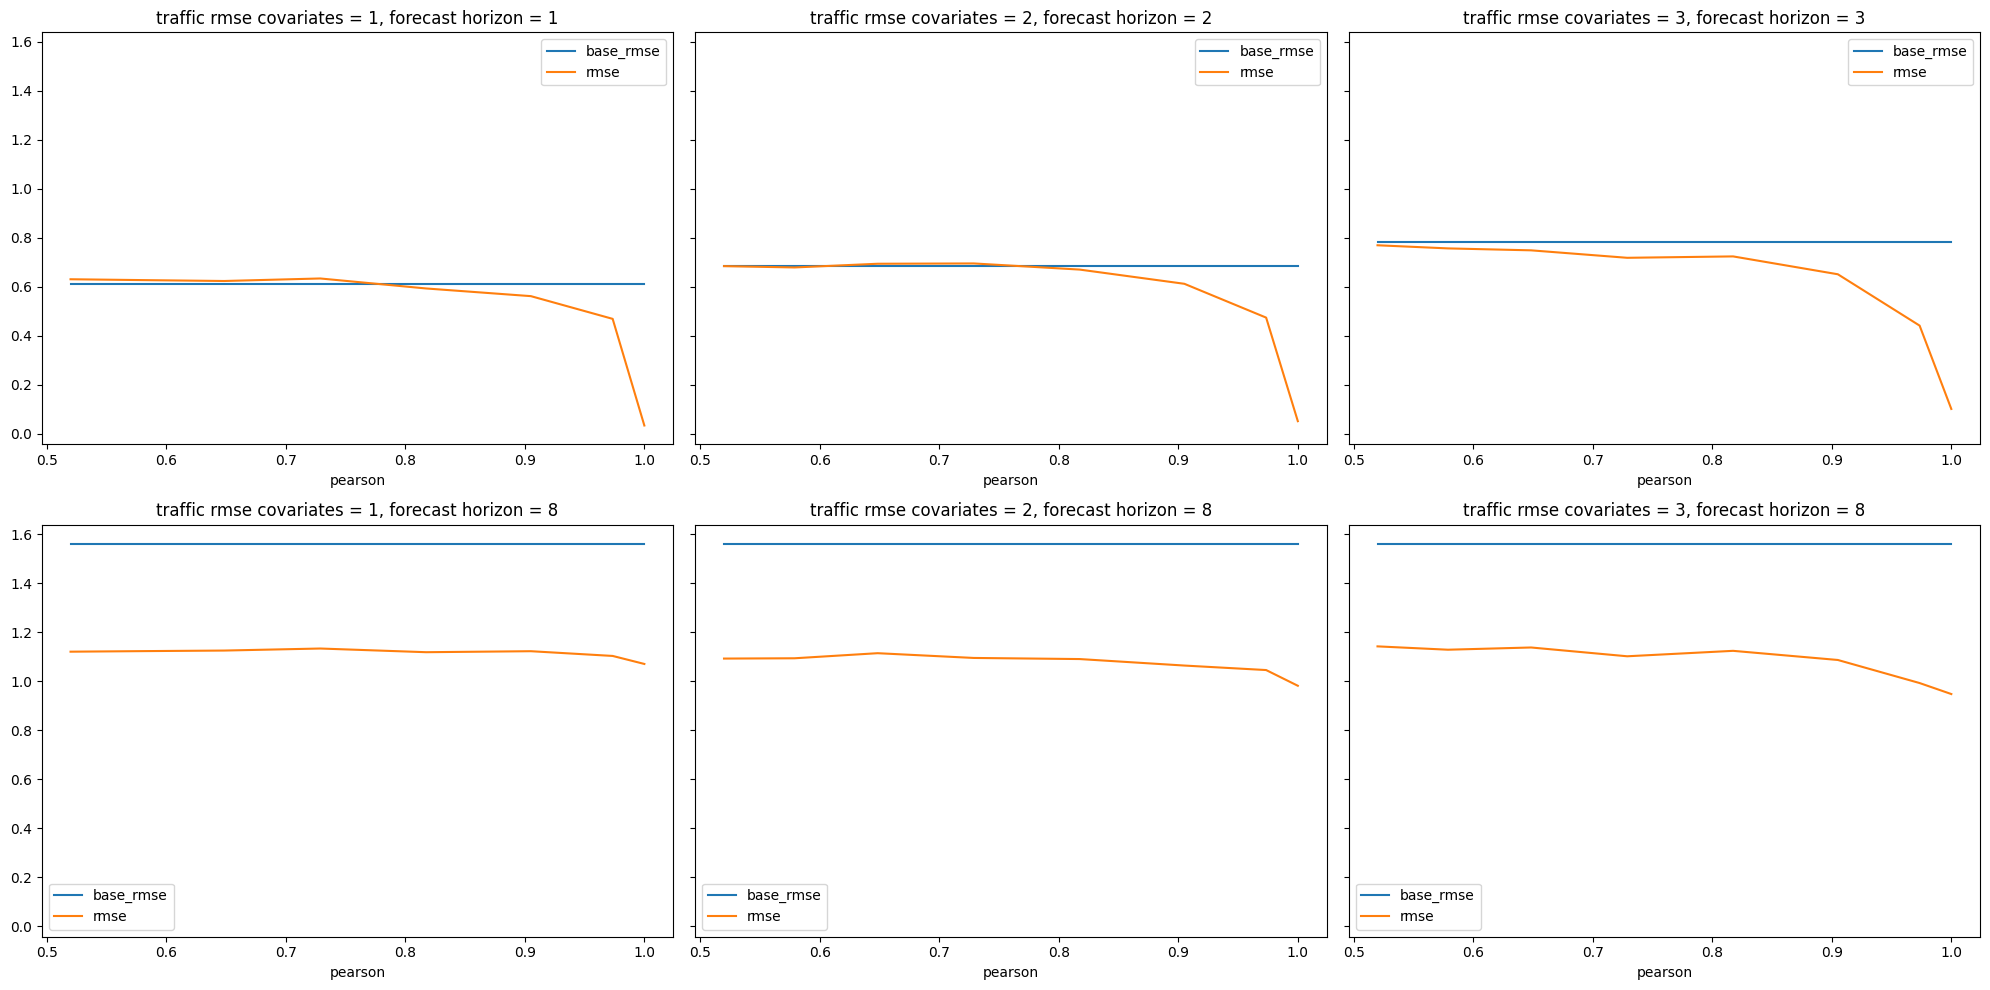

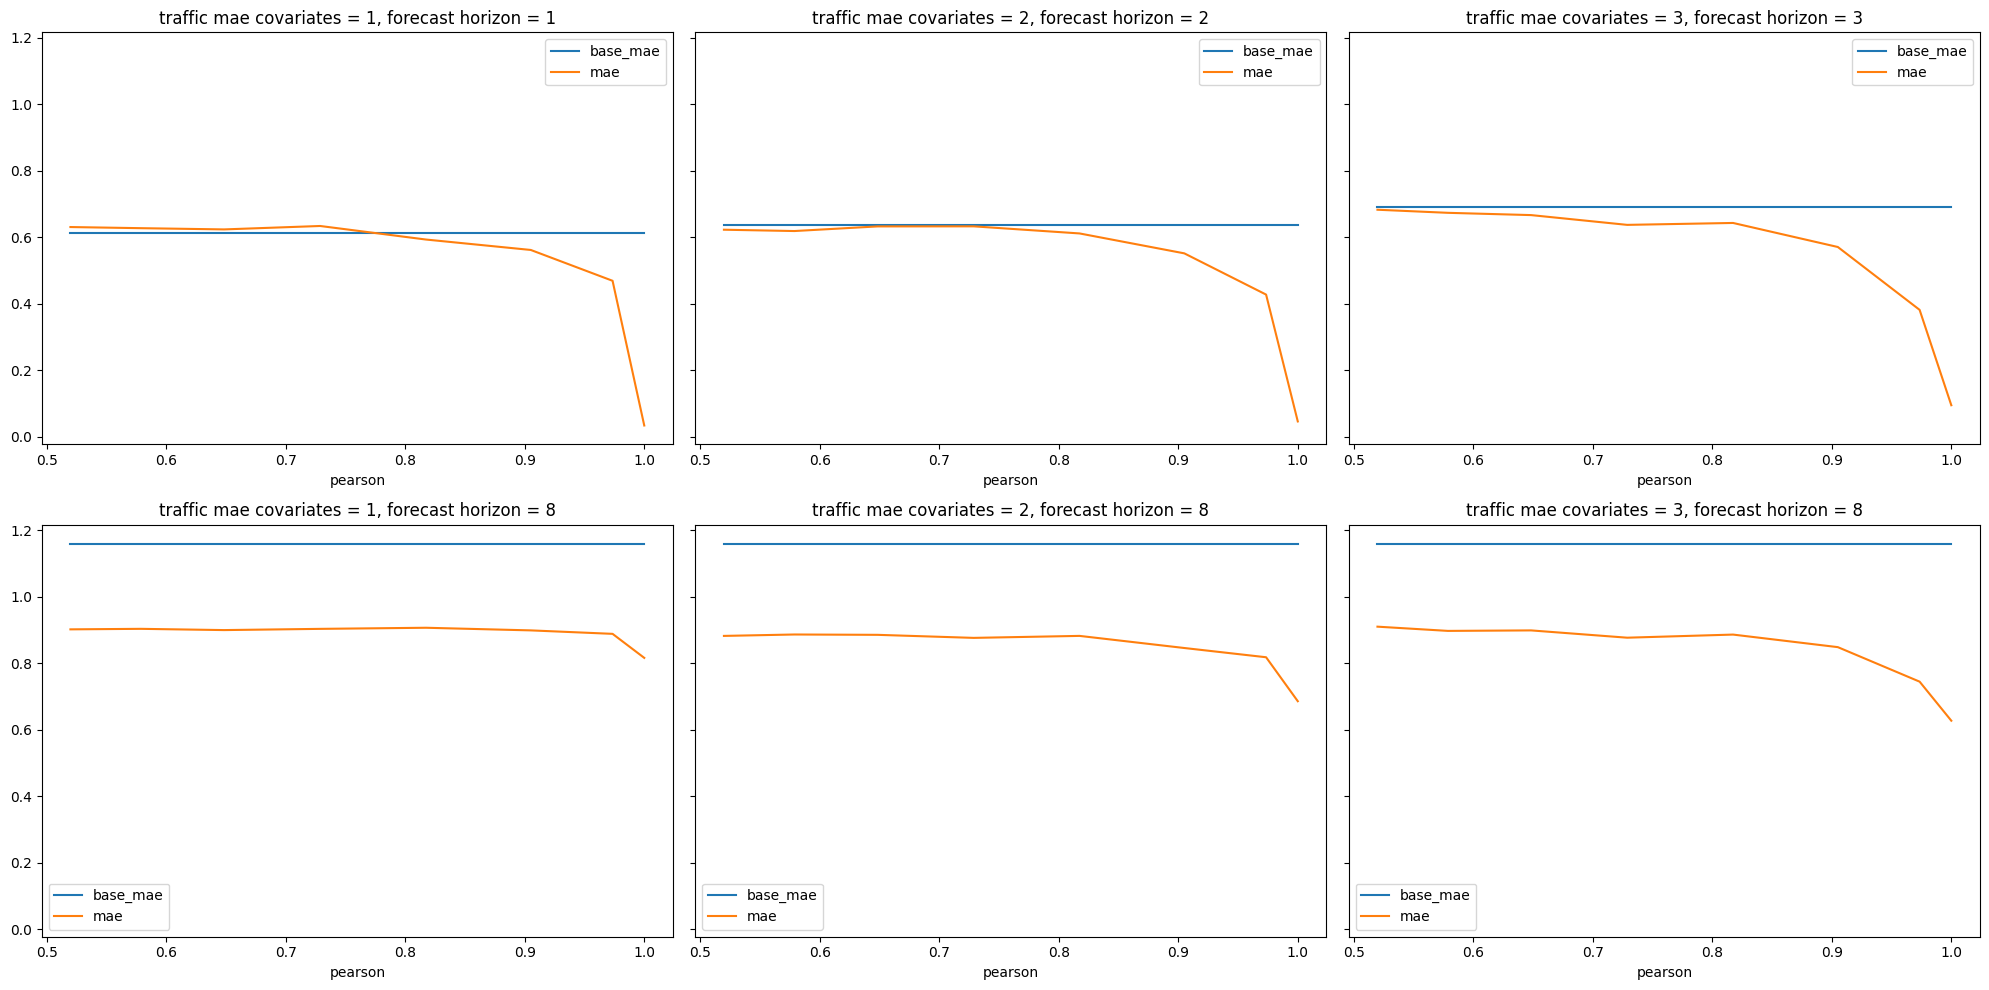

In [30]:
#results = pd.read_csv(f"{PATH}/results.csv")

for metric in ["smape", "mape", "rmse", "mae"]:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)
    covs.get_chart_data(results, 1, 1, metric).plot(
        kind="line",
        ax=axes[0, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = 1",
    )
    covs.get_chart_data(results, 2, 2, metric).plot(
        kind="line",
        ax=axes[0, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = 2",
    )
    covs.get_chart_data(results, 3, 3, metric).plot(
        kind="line",
        ax=axes[0, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = 3",
    )
    covs.get_chart_data(results, metadata.prediction_length, 1, metric).plot(
        kind="line",
        ax=axes[1, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 2, metric).plot(
        kind="line",
        ax=axes[1, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 3, metric).plot(
        kind="line",
        ax=axes[1, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = {metadata.prediction_length}",
    )
    fig.tight_layout()
    fig.savefig(f"{PATH}/{metric}.png")

In [20]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

IndexError: index 360 is out of bounds for dimension 0 with size 360

In [31]:
results.loc[(results['covariates']==0) & (results['prediction_length']==metadata.prediction_length),['smape', 'mape', 'rmse', 'mae']].mean()

smape    0.129747
mape          inf
rmse     1.580042
mae      1.167390
dtype: float64